# Drive Mount

In [1]:

from google.colab import drive
drive.mount('/content/drive')

dataset = "/content/drive/My Drive/Thesis/deepfake-detection-master/deepfake_database.zip"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Extract dataset

In [2]:
%%capture
!unzip -o "/content/drive/My Drive/Thesis/deepfake-detection-master/deepfake_database.zip" -d /content/

# Preprocessing

## Folder Paths

In [3]:
import os
#directory = "Desktop/Thesis/datasets/deepfake_database/deepfake_database/deepfake_database/train_test"
directory = os.path.join('deepfake_database', 'train_test')
image_format = '.jpg'

## Data Params

In [4]:
BATCH_SIZE = 75
SIZE = 256

## Store into tf.data.Dataset

In [5]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

training_dataset = image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    class_names=['df', 'real'],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(SIZE, SIZE),
    shuffle=True,
    seed=123,
    validation_split=0.3,
    subset="training",
    interpolation="bilinear",
)

validation_dataset = image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    class_names=['df', 'real'],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(SIZE, SIZE),
    shuffle=True,
    seed=123,
    validation_split=0.3,
    subset="validation",
    interpolation="bilinear",
)

Found 12353 files belonging to 2 classes.
Using 8648 files for training.
Found 12353 files belonging to 2 classes.
Using 3705 files for validation.


# Model

## Model Params

In [6]:
input_shape = (SIZE, SIZE, 3)
learning_rate = 0.001
dl_rate = 1
EPOCHS = 50
ITERATIONS = len(training_dataset) * EPOCHS
print(ITERATIONS)

5800


## LR Decay

In [7]:
'''
import tensorflow as tf
from keras.optimizers.schedules import PiecewiseConstantDecay
step = tf.Variable(0, trainable=False)
boundaries = [1000, 1000, 1000]
values = [0.001, 0.0001, 0.00001, 0.000001]
learning_rate_fn = PiecewiseConstantDecay(boundaries, values)

# Later, whenever we perform an optimization step, we pass in the step.
learning_rate = learning_rate_fn(step)

'''

'\nimport tensorflow as tf\nfrom keras.optimizers.schedules import PiecewiseConstantDecay\nstep = tf.Variable(0, trainable=False)\nboundaries = [1000, 1000, 1000]\nvalues = [0.001, 0.0001, 0.00001, 0.000001]\nlearning_rate_fn = PiecewiseConstantDecay(boundaries, values)\n\n# Later, whenever we perform an optimization step, we pass in the step.\nlearning_rate = learning_rate_fn(step)\n\n'

In [8]:
# This function keeps the initial learning rate for the first ten epochs  
# and decreases it exponentially after that.  
def scheduler(epoch, lr):
    print("{0:.8f}".format(lr))
    if epoch < 20:
        return 0.001 # lr = 0.001
    elif epoch >= 20 and epoch < 30:
        return 0.001 # lr = 0.00001
    elif epoch >= 30 and epoch < 40:
        return 0.0001 # lr = 0.00001
    elif epoch >= 40:
        return 0.0001 # lr = 0.000001

## Custom Callback

## Compile Model

In [10]:
from keras.models import Model as KerasModel
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from keras.optimizers import Adam

%run -i 'classifiers.py'

model, modelName = Meso4VGG16(input_shape)
optimizer = Adam(lr = learning_rate)
model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
# round(model.optimizer.lr.numpy(), 5)
# model.summary()
print(modelName)

Meso4VGG16


# Training

## Fit Model

In [12]:
from tensorflow import keras
import keras.backend as K

callback = keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(training_dataset, epochs=EPOCHS, validation_data=validation_dataset, verbose = 1, callbacks=[callback])
round(model.optimizer.lr.numpy(), 5)


Epoch 1/50
0.00100000
116/116 [==============================] - 35s 265ms/step - loss: 0.2545 - accuracy: 0.6212 - val_loss: 0.2792 - val_accuracy: 0.4524
Epoch 2/50
0.00100000
116/116 [==============================] - 30s 256ms/step - loss: 0.1556 - accuracy: 0.7951 - val_loss: 0.3264 - val_accuracy: 0.5900
Epoch 3/50
0.00100000
116/116 [==============================] - 31s 257ms/step - loss: 0.1415 - accuracy: 0.8165 - val_loss: 0.4093 - val_accuracy: 0.5463
Epoch 4/50
0.00100000
116/116 [==============================] - 30s 257ms/step - loss: 0.1198 - accuracy: 0.8477 - val_loss: 0.1042 - val_accuracy: 0.8653
Epoch 5/50
0.00100000
116/116 [==============================] - 30s 257ms/step - loss: 0.0870 - accuracy: 0.8877 - val_loss: 0.1712 - val_accuracy: 0.8043
Epoch 6/50
0.00100000
116/116 [==============================] - 30s 257ms/step - loss: 0.0889 - accuracy: 0.8895 - val_loss: 0.2817 - val_accuracy: 0.6947
Epoch 7/50
0.00100000
116/116 [==============================] -

## Training and Validation Graphs

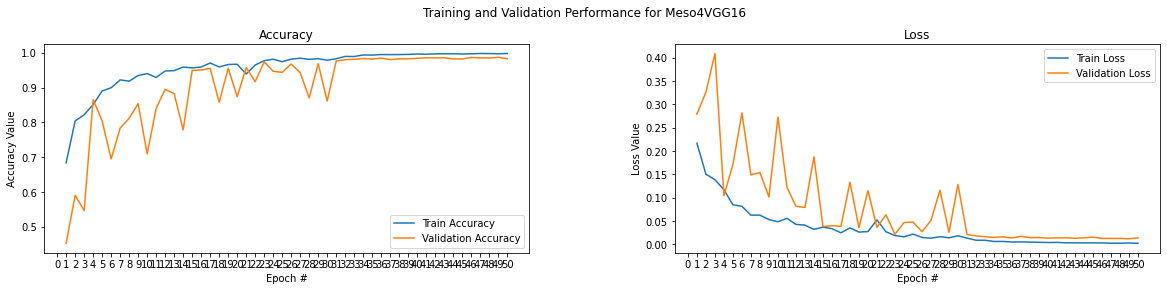

In [13]:
import matplotlib.pyplot as plt
import numpy as np

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Training and Validation Performance for ' + modelName, fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Prediction

## Folder Paths

In [14]:
import os
directory = os.path.join('deepfake_database', 'validation')
image_format = '.jpg'

## Store into tf.data.Dataset

In [15]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 75

test_dataset = image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    class_names=['df', 'real'],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(SIZE, SIZE),
    shuffle=False,
    interpolation="bilinear",
)

Found 7104 files belonging to 2 classes.


## Make Prediction

In [16]:
import numpy as np
Y_pred = (model.predict(test_dataset, verbose=1) > 0.5).astype("int32")

95/95 [==============================] - 13s 139ms/step


## Read Original Labels

In [17]:
Y_test = []
for img_array, label in (test_dataset.as_numpy_iterator()):
    Y_test.append(label)

## Flatten Original and Prediction label arrays

In [18]:
import numpy as np

original_labels = []
original_labels = list(np.concatenate(Y_test).flat)
original_labels = np.array(original_labels)

predicted_labels = []
predicted_labels = list(np.concatenate(Y_pred).flat)
predicted_labels = np.array(predicted_labels)

## Classification Report

In [21]:
from sklearn.metrics import classification_report
classificationReport = classification_report(original_labels, predicted_labels, target_names=test_dataset.class_names)
print(classificationReport)

              precision    recall  f1-score   support

          df       0.87      0.93      0.90      2845
        real       0.95      0.90      0.93      4259

    accuracy                           0.92      7104
   macro avg       0.91      0.92      0.91      7104
weighted avg       0.92      0.92      0.92      7104



## Confusion Matrix

True positive =  2654
False positive =  191
False negative =  409
True negative =  3850




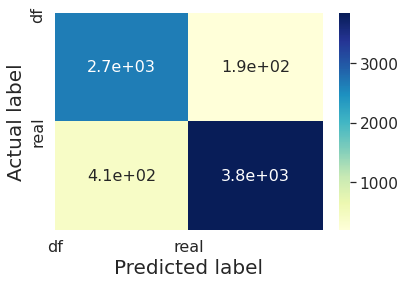

In [22]:
#Output confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu") # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), test_dataset.class_names, size = 16)
    plt.yticks(np.arange(2), test_dataset.class_names, size = 16)
    plt.ylim([2, 0])
    plt.show()
    return cm
    
confusionMatrix = print_confusion_matrix(original_labels, predicted_labels)

# Write to File

In [61]:
import os

tp = str('True positive = '+ str(confusionMatrix[0][0]) + '\n')
fp = str('False positive = '+ str(confusionMatrix[0][1]) + '\n')
fn = str('False negative = '+ str(confusionMatrix[1][0]) + '\n')
tn = str('True negative = '+ str(confusionMatrix[1][1]) + '\n')

data = (
    'Model Name: ' + str(modelName) + '\n' +
    'Batch Size: ' + str(BATCH_SIZE) + '\n' +
    'Image Size: ' + str(SIZE) + '\n' +
    'Epochs: ' + str(EPOCHS) + '\n' +
    'Iterations: ' + str(ITERATIONS) + '\n' +
    '===================================================== \n\n' +
    str(classificationReport) + '\n' + str(tp + fp + fn + tn)
)

from datetime import datetime 
import pytz 
  
# get the standard UTC time  
UTC = pytz.utc 
  
# it will get the time zone  
# of the specified location 
IST = pytz.timezone('Asia/Kolkata') 
  
datetime_ist = datetime.now(IST) 
filename = ('Report ' + datetime_ist.strftime('%Y-%m-%d %H%M') + ' ' + modelName + '.txt')

myFile = open(filename, 'w')
myFile.write(data)
myFile.close()

model.save(modelName + ' ' + datetime_ist.strftime('%Y-%m-%d %H%M') + '.h5')